In [1]:
#This is NOT the code used in our paper: Sci Rep 15, 25091 (2025), but an example srcipt of how to implement mouse-mimetic layers in the DC-GAN.
#Modified from https://keras.io/examples/generative/dcgan_overriding_train_step/

import keras
import tensorflow as tf

from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os

2025-08-14 02:28:53.152034: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 02:28:53.169210: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755138533.189748   18096 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755138533.196090   18096 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-14 02:28:53.217897: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
print(keras.__version__)
print(tf.__version__)

3.11.1
2.18.1


In [3]:
#Exec "pip install kagglehub" from the command prompt beforehand.
import kagglehub
# Download latest version
path = kagglehub.dataset_download("andrewmvd/animal-faces")
print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████████| 696M/696M [00:02<00:00, 247MB/s]

Extracting files...


Path to dataset files: /home/ubuntu/.cache/kagglehub/datasets/andrewmvd/animal-faces/versions/1


In [4]:
dataset = keras.utils.image_dataset_from_directory(
    path + "/afhq/train/cat", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 5153 files.


I0000 00:00:1755138550.955708   18096 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13760 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:1e.0, compute capability: 7.5


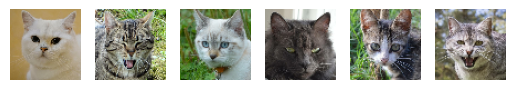

In [5]:
im=1
for x in dataset:
    plt.subplot(1,6, im)
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    plt.axis("off")
    im = im+1
    if (im>6): break

In [6]:
import mouselayers as mouse

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.SpectralNormalization(layers.Conv2D(64, kernel_size=4, strides=2, padding="same")),
        layers.LeakyReLU(negative_slope=0.2),
        layers.SpectralNormalization(layers.Conv2D(128, kernel_size=4, strides=2, padding="same")),
        layers.LeakyReLU(negative_slope=0.2),
        layers.SpectralNormalization(layers.Conv2D(256, kernel_size=4, strides=2, padding="same")),
        layers.LeakyReLU(negative_slope=0.2),
        layers.SpectralNormalization(layers.Conv2D(512, kernel_size=4, strides=2, padding="same")),
        layers.LeakyReLU(negative_slope=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ spectral_normalization          │ (None, 32, 32, 64)     │         3,200 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_1        │ (None, 16, 16, 128)    │       131,328 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_2        │ (None, 8, 8, 256)      │       524,800 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spectral_normalization_3        │ (None, 4, 4, 512)      │     2,098,176 │
│ (SpectralNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,765,697 (10.55 MB)

 Trainable params: 2,764,737 (10.55 MB)

 Non-trainable params: 960 (3.75 KB)

In [8]:
latent_dim = 128
#parameter usage: wnd=0.4 => ~35% weights are used and other 65% are disabled.
wnd = 0.4

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(4 * 4 * 1024),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Reshape((4, 4, 1024)),
        mouse.mConv2DTranspose(512, form='2d', input2d_width=32, output2d_width=32, window2d_width=wnd, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        mouse.mConv2DTranspose(256, form='2d', input2d_width=32, output2d_width=16, window2d_width=wnd, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        mouse.mConv2DTranspose(128, form='2d', input2d_width=16, output2d_width=16, window2d_width=wnd, kernel_size=5, strides=2, padding="same"),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 16384)          │     2,113,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m_conv2d_transpose              │ (None, 8, 8, 512)      │    13,107,712 │
│ (mConv2DTranspose)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m_conv2d_transpose_1            │ (None, 16, 16, 256)    │     3,277,056 │
│ (mConv2DTranspose)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ m_conv2d_transpose_2            │ (None, 32, 32, 128)    │       819,328 │
│ (mConv2DTranspose)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 64, 64, 3)      │         9,603 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,396,355 (73.99 MB)

 Trainable params: 19,361,795 (73.86 MB)

 Non-trainable params: 34,560 (135.00 KB)

In [9]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = ops.concatenate([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = keras.random.normal(
            shape=(self.num_img, self.latent_dim), seed=self.seed_generator
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [11]:
epochs = 200

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/200


I0000 00:00:1755135059.751166   13925 service.cc:148] XLA service 0x73d2c80034a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755135059.751202   13925 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-08-14 01:31:01.172518: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-08-14 01:31:01.290491: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:61] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform/RandomUniform
I0000 00:00:1755135062.505812   13925 cuda_dnn.cc:529] Loaded cuDNN version 90501


  1/162 ━━━━━━━━━━━━━━━━━━━━ 1:49:19 41s/step - d_loss: 0.6938 - g_loss: 0.7768

I0000 00:00:1755135072.531839   13925 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


162/162 ━━━━━━━━━━━━━━━━━━━━ 66s 154ms/step - d_loss: 0.4904 - g_loss: 1.3311
Epoch 2/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - d_loss: 0.4552 - g_loss: 1.5021
Epoch 3/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - d_loss: 0.3596 - g_loss: 2.2339
Epoch 4/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - d_loss: 0.3610 - g_loss: 2.1097
Epoch 5/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - d_loss: 0.3655 - g_loss: 2.2273
Epoch 6/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - d_loss: 0.3994 - g_loss: 2.0725
Epoch 7/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - d_loss: 0.4164 - g_loss: 1.8561
Epoch 8/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - d_loss: 0.4311 - g_loss: 1.8325
Epoch 9/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - d_loss: 0.5191 - g_loss: 1.6681
Epoch 10/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - d_loss: 0.4677 - g_loss: 1.5725
Epoch 11/200
162/162 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - d_loss: 0.4864 - g_loss: 1.6858
Epoch 12/200
162/162 ━

GAN images


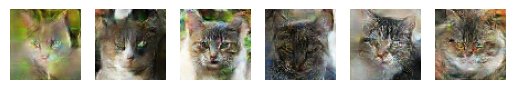

In [12]:
print("GAN images")
import glob
import matplotlib.image as mpimg
image_files = glob.glob(os.path.join('*_199_?.png'))
images = [mpimg.imread(path) for path in image_files]
fig, axes = plt.subplots(1, 6)
for i, ax in enumerate(axes.flat):
    if i < len(images):
        ax.imshow(images[i])
        ax.axis('off')
plt.show()

Real photos


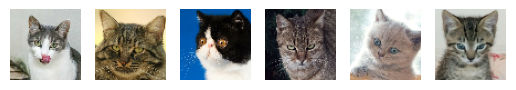

In [13]:
print("Real photos")
im=1
for x in dataset:
    plt.subplot(1,6, im)
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    plt.axis("off")
    im = im+1
    if (im>6): break